Going to attempt to build some keras layers for text and benchmark that against datarobot text-only models on the leaderboard.   Going to use the file DR_zid_sw_2016-06-30.gz  which corresponds to https://app.datarobot.com/projects/586de94dc8089157b1c70876/models

These are the text models below

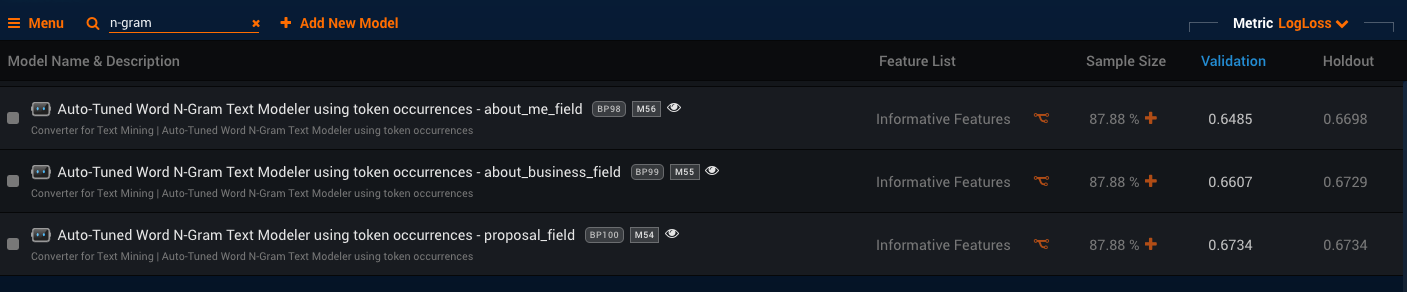

In [1]:
from IPython.display import Image
Image("text_models.png")

### Import Data

In [65]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers.convolutional import Convolution1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import MaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam #https://keras.io/optimizers/
from keras.layers.normalization import BatchNormalization #https://keras.io/layers/normalization/
from keras.regularizers import WeightRegularizer #https://keras.io/regularizers/
pd.options.display.max_columns = 100

In [3]:
df = pd.read_csv('DR_zid_sw_2016-06-30.gz')

Lets tackle the text feature proposal_field first

In [4]:
df_text = df[['proposal_field', 'default_flag','part']]
#Fill null values with empty string
df.proposal_field[df.proposal_field.isnull()] = ''
df_text.head()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,proposal_field,default_flag,part
0,Thank you for giving me this opportunity to ap...,0,t
1,The first loan given will be used to aid in re...,1,t
2,The first loan given will be used to purchase ...,0,t
3,Thank you all the zidisha Microfinance for the...,1,t
4,"I will use KES 15,000 to add up to my savings ...",0,t


In [202]:
#set max vocabulary
max_words = 3000
text_tokenizer = Tokenizer(nb_words=max_words)

In [209]:
#train validation holdout split
train = df[df.part == 't'].proposal_field.values.tolist()
train_labels = df[df.part == 't'].default_flag.values.tolist()

validation = df[df.part == 'v'].proposal_field.values.tolist()
validation_labels =  df[df.part == 'v'].default_flag.values.tolist()

holdout = df[df.part == 'h'].proposal_field.values.tolist()
holdout_labels = df[df.part == 'h'].default_flag.values.tolist()

#Fit data on training set
text_tokenizer.fit_on_texts(train)

In [223]:
#Transform datasets
mode = 'binary'
train_transformed = text_tokenizer.texts_to_matrix(train, mode = mode)
validation_transformed = text_tokenizer.texts_to_matrix(validation, mode = mode)
holdout_transformed = text_tokenizer.texts_to_matrix(holdout, mode = mode)

In [246]:
model = Sequential([ 
    #Embedding(max_words, 32, input_length=seq_len, dropout=0.2),
    BatchNormalization(input_shape=(max_words,)), #Normalizes input
    #Convolution1D(2, 10, border_mode='same', activation='relu'),
    #Flatten(),    
    #Dense(2, activation='relu', W_regularizer=WeightRegularizer(l1=0.1, l2=0.1)),
    Dropout(.2),
    #Dense(100, activation='relu', W_regularizer=WeightRegularizer(l1=0.1, l2=0.1)),
    #BatchNormalization(),
    #Dropout(.1),
    Dense(1, activation='sigmoid',W_regularizer=WeightRegularizer(l1=.01, l2=0.2))])

model.compile(loss='binary_crossentropy', optimizer=Adam(lr = .0001), metrics=['accuracy'])

In [247]:
model.fit(train_transformed, train_labels, validation_data=(validation_transformed, validation_labels), 
          nb_epoch=6, batch_size=64)

Train on 20266 samples, validate on 2408 samples
Epoch 1/6
20266/20266 [==============================] - 2s - loss: 1.4283 - acc: 0.5371 - val_loss: 1.1400 - val_acc: 0.4273
Epoch 2/6
20266/20266 [==============================] - 2s - loss: 0.9330 - acc: 0.5718 - val_loss: 0.8340 - val_acc: 0.5332
Epoch 3/6
20266/20266 [==============================] - 2s - loss: 0.7484 - acc: 0.5950 - val_loss: 0.7311 - val_acc: 0.5540
Epoch 4/6
20266/20266 [==============================] - 2s - loss: 0.7006 - acc: 0.6083 - val_loss: 0.7095 - val_acc: 0.5478
Epoch 5/6
20266/20266 [==============================] - 2s - loss: 0.6895 - acc: 0.6097 - val_loss: 0.7076 - val_acc: 0.5158
Epoch 6/6
20266/20266 [==============================] - 2s - loss: 0.6861 - acc: 0.6073 - val_loss: 0.7097 - val_acc: 0.4934


In [248]:
model.evaluate(holdout_transformed, holdout_labels)

387/387 [==============================] - 0s     


[0.71019592688681232, 0.509043927802596]

# Part 2: Try Convolutional Network

In [251]:
df.proposal_field.apply(lambda x: len(x)).describe()

count    23061.000000
mean       495.843198
std        365.120189
min          0.000000
25%        305.000000
50%        431.000000
75%        618.000000
max      13586.000000
Name: proposal_field, dtype: float64

### Pre-process Text

In [376]:
seq_len = 500

seq_train_transformed = text_tokenizer.texts_to_sequences(train)
trn = pad_sequences(seq_train_transformed, maxlen=seq_len, value=0)

seq_validation_transformed = text_tokenizer.texts_to_sequences(validation)
vld = pad_sequences(seq_validation_transformed, maxlen=seq_len, value=0)

### Define Network Topology

This took lots of trial and error.  Intuition behind network topology:

- I found from previous step that less dense layers performed better.  Infact, when only having 1 dense layer with just a single node did the best!  Therefore, I eliminated all Dense layers and focused on convolution to see if I could improve upon the last model.


- I wanted to emulate n-gram (bag of words, bi-grams, tri-grams, etc. but I wanted to instead try something conceptually similar (and more elegant), which is to use a 1-dimensional convolution that slides over the text.   A big window of about 15 words long seemd to work the best in this case.  


- I increased regularization to the point where it did not negatively impact model performance, with the idea that I want the most constrained model that is the most accurate.  I found that L1 regularization was not effective in the last layer and stuck with tuning L2

### TODO:  

- Checkpoint best model during training, instead of just getting the model at the end of predefined epoch runs

In [486]:
model_conv = Sequential([ 
    Embedding(max_words, 3, input_length=seq_len, dropout=0.2),
    Dropout(.5),
    Convolution1D(2, 15, border_mode='same', activation='tanh'),
    BatchNormalization(), #Normalizes input
    MaxPooling1D(10),
    Flatten(),
    Dropout(.7),
    Dense(1, activation='sigmoid', W_regularizer=WeightRegularizer(l2=.95))])

model_conv.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

### Fit Model And Evaluate
Now we will train model and see score on validation set, and compare with DataRobot

In [487]:
model_conv.fit(trn, train_labels, validation_data=(vld, validation_labels),
              nb_epoch=4, batch_size=64)

Train on 20266 samples, validate on 2408 samples
Epoch 1/4
20266/20266 [==============================] - 3s - loss: 1.1209 - acc: 0.5505 - val_loss: 0.7233 - val_acc: 0.4020
Epoch 2/4
20266/20266 [==============================] - 3s - loss: 0.6803 - acc: 0.5899 - val_loss: 0.7168 - val_acc: 0.4020
Epoch 3/4
20266/20266 [==============================] - 3s - loss: 0.6759 - acc: 0.5900 - val_loss: 0.7193 - val_acc: 0.4020
Epoch 4/4
20266/20266 [==============================] - 3s - loss: 0.6751 - acc: 0.5900 - val_loss: 0.7244 - val_acc: 0.4020


** I noticed model start to diverge after a while, so I slowed down learning rate and kept going **

In [488]:
model_conv.optimizer.lr = 1e-4

In [489]:
model_conv.fit(trn, train_labels, validation_data=(vld, validation_labels),
              nb_epoch=12, batch_size=64)

Train on 20266 samples, validate on 2408 samples
Epoch 1/12
20266/20266 [==============================] - 3s - loss: 0.6743 - acc: 0.5900 - val_loss: 0.7232 - val_acc: 0.4020
Epoch 2/12
20266/20266 [==============================] - 3s - loss: 0.6744 - acc: 0.5900 - val_loss: 0.7159 - val_acc: 0.4020
Epoch 3/12
20266/20266 [==============================] - 3s - loss: 0.6732 - acc: 0.5900 - val_loss: 0.7155 - val_acc: 0.4020
Epoch 4/12
20266/20266 [==============================] - 3s - loss: 0.6716 - acc: 0.5900 - val_loss: 0.7091 - val_acc: 0.4020
Epoch 5/12
20266/20266 [==============================] - 3s - loss: 0.6707 - acc: 0.5900 - val_loss: 0.7028 - val_acc: 0.4070
Epoch 6/12
20266/20266 [==============================] - 3s - loss: 0.6690 - acc: 0.5906 - val_loss: 0.6937 - val_acc: 0.5814
Epoch 7/12
20266/20266 [==============================] - 3s - loss: 0.6673 - acc: 0.5931 - val_loss: 0.6897 - val_acc: 0.6076
Epoch 8/12
20266/20266 [==============================] - 3s -

**Evaluate on holdout set**

In [490]:
seq_holdout_transformed = text_tokenizer.texts_to_sequences(holdout)
hld = pad_sequences(seq_holdout_transformed, maxlen=seq_len, value=0)

In [491]:
model_conv.evaluate(hld, holdout_labels)

387/387 [==============================] - 0s     


[0.69362824924232425, 0.52713178294573648]

### Visualize Model Architecture

lets see holdout score

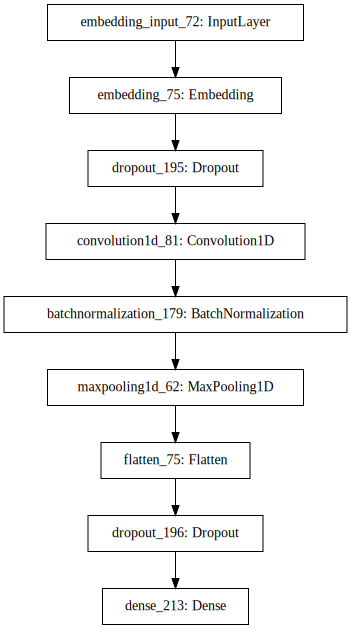

In [492]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model_conv).create(prog='dot', format='svg'))

In [493]:
model_conv.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_75 (Embedding)         (None, 500, 3)        9000        embedding_input_72[0][0]         
____________________________________________________________________________________________________
dropout_195 (Dropout)            (None, 500, 3)        0           embedding_75[0][0]               
____________________________________________________________________________________________________
convolution1d_81 (Convolution1D) (None, 500, 2)        92          dropout_195[0][0]                
____________________________________________________________________________________________________
batchnormalization_179 (BatchNor (None, 500, 2)        8           convolution1d_81[0][0]           
___________________________________________________________________________________________